In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# set up arrays
dx = 1000
x = np.arange(0, 100000, dx)
x_node = x + (dx/2)

Hstar = 0.5
etab = np.zeros(len(x)) # bedrock elevation, m
etab[:] = np.linspace(10, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x))
eta = etab + H

In [3]:
# set up parameters
# K_ig = np.zeros(len(x))
# K_ig[:24] = 1e-7
# K_sed = np.zeros(len(x))
# K_sed[24:] = 1e-6
K = np.zeros(len(x))
K[:] = 1e-7

# beta_ig = np.zeros(len(x))
# beta_ig[:24] = 4e-7
# beta_sed = np.zeros(len(x))
# beta_sed[24:] = 4e-6
beta = np.zeros(len(x))
beta[:] = 1e-6
# beta[:] = 1e-6

# psi = np.zeros(len(x))
# psi[:14] = 4e-7
# psi[14:] = 4e-6
psi = 1e-6
# psi = 1e-6
# psi = 1e-5
gamma = 0.3

r = 10. # runoff rate
D = 0.015 # grain size
phi = 0.45 # porosity
baselevel_rate = 0.00055 # baselevel fall rate

In [4]:
kqs = 0.041
I = 0.01
kxb = 25
Pxb = 1./5.
kb = 8.3e-8

B_valley = kxb * (x_node**Pxb)
B_basin = (2./3.) * x_node

area = (1./3.) * x**2
# Q = r * x * B
Q = r * area

In [5]:
def model(x, dx, x_node,
          K, beta,
          D, phi, Hstar, psi, gamma,
          kb, kqs, I, r, B_valley, B_basin, Q,
          etab, H, eta,
          baselevel_rate,
          num_steps = 1):
    
    q = Q/B_valley
    # dt = 0.2 * dx * dx / (kqs * q[-1]) # try changing to 10, 5, or 1 if this is unstable
    dt = 5
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    ql = np.zeros(len(x))
    
    H[-1] = 0
    E[-1] = baselevel_rate
    q[0] = 0
    Qs[0] = 0
    ql[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= baselevel_rate * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc Rh
#         width = (kb * Q[1:] * (S ** (7/6))) / (D**(3/2))
#         depth = (0.09801 * D) / S
#         Rh_efficiency = 1 - np.exp(-width/(2*depth))
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1]) # * Rh_efficiency
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p[:-1] = K[1:] * Q[1:] * S * alpha[:-1]
        Eb_a[:-1] = beta[1:] * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc grain attrition
        atr = Qs * psi
        
        # calc equilibrium lateral supply
        ql[1:] = ((baselevel_rate * gamma) / psi) * (1 - np.exp(-psi/(3 * x[1:])))
        # ql[24:] = 0
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - Eb_p[:-1] - ql[1:])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, atr, ql, Eh, E, etab, H, eta)

In [6]:
#now write a test
num_steps = 5000000
test_run = [x, dx, x_node, 
            K, beta, 
            D, phi, Hstar, psi, gamma,
            kb, kqs, I, r, B_valley, B_basin, Q,
            etab, H, eta,
            baselevel_rate,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, atr, ql, Eh, E, etab, H, eta) = model(*test_run)

25000000.0


In [7]:
Eb

array([0.00055, 0.00055, 0.00055, 0.00055, 0.00055, 0.00055, 0.00055,
       0.00055, 0.00055, 0.00055, 0.00055, 0.00055, 0.00055, 0.00055,
       0.00055, 0.00055, 0.00055, 0.00055, 0.00055, 0.00055, 0.00055,
       0.00055, 0.00055, 0.00055, 0.00055, 0.00055, 0.00055, 0.00055,
       0.00055, 0.00055, 0.00055, 0.00055, 0.00055, 0.00055, 0.00055,
       0.00055, 0.00055, 0.00055, 0.00055, 0.00055, 0.00055, 0.00055,
       0.00055, 0.00055, 0.00055, 0.00055, 0.00055, 0.00055, 0.00055,
       0.00055, 0.00055, 0.00055, 0.00055, 0.00055, 0.00055, 0.00055,
       0.00055, 0.00055, 0.00055, 0.00055, 0.00055, 0.00055, 0.00055,
       0.00055, 0.00055, 0.00055, 0.00055, 0.00055, 0.00055, 0.00055,
       0.00055, 0.00055, 0.00055, 0.00055, 0.00055, 0.00055, 0.00055,
       0.00055, 0.00055, 0.00055, 0.00055, 0.00055, 0.00055, 0.00055,
       0.00055, 0.00055, 0.00055, 0.00055, 0.00055, 0.00055, 0.00055,
       0.00055, 0.00055, 0.00055, 0.00055, 0.00055, 0.00055, 0.00055,
       0.00055, 0.  

In [8]:
eta

array([-12910.53122117, -13099.33965692, -13173.91693782, -13219.25819468,
       -13252.01127134, -13277.86817412, -13299.38962725, -13317.93312308,
       -13334.3015112 , -13349.00820339, -13362.40130793, -13374.72781832,
       -13386.16944756, -13396.8638879 , -13406.91806361, -13416.41673869,
       -13425.42830442, -13434.00878747, -13442.20469755, -13450.0550961 ,
       -13457.59312892, -13464.84718153, -13471.84176375, -13478.59819654,
       -13485.13515188, -13491.46908225, -13497.61456559, -13503.58458524,
       -13509.39075896, -13515.04352792, -13520.55231366, -13525.92564957,
       -13531.17129153, -13536.29631168, -13541.3071783 , -13546.20982423,
       -13551.00970575, -13555.71185351, -13560.32091667, -13564.84120152,
       -13569.27670515, -13573.63114508, -13577.90798545, -13582.11046001,
       -13586.24159269, -13590.30421581, -13594.30098634, -13598.23440043,
       -13602.10680652, -13605.92041702, -13609.67731892, -13613.37948333,
       -13617.02877414, -

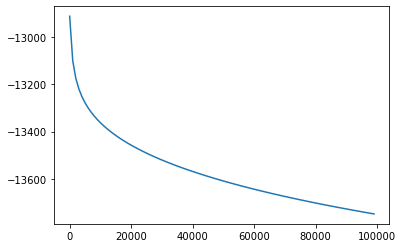

In [9]:
plt.plot(x, eta)

In [10]:
eta_adj = eta - eta[-1]

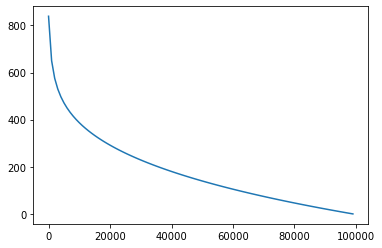

In [11]:
plt.plot(x, eta_adj)

In [12]:
eta_adj

array([838.86877772, 650.06034196, 575.48306107, 530.14180421,
       497.38872755, 471.53182476, 450.01037164, 431.46687581,
       415.09848769, 400.3917955 , 386.99869096, 374.67218057,
       363.23055133, 352.53611099, 342.48193528, 332.9832602 ,
       323.97169447, 315.39121142, 307.19530134, 299.34490279,
       291.80686997, 284.55281736, 277.55823514, 270.80180235,
       264.26484701, 257.93091664, 251.7854333 , 245.81541365,
       240.00923993, 234.35647097, 228.84768523, 223.47434932,
       218.22870736, 213.10368721, 208.09282059, 203.19017466,
       198.39029314, 193.68814538, 189.07908222, 184.55879737,
       180.12329374, 175.76885381, 171.49201344, 167.28953888,
       163.1584062 , 159.09578308, 155.09901255, 151.16559846,
       147.29319237, 143.47958187, 139.72267997, 136.02051555,
       132.37122475, 128.77304306, 125.22429822, 121.72340376,
       118.26885302, 114.85921378, 111.49312329, 108.16928371,
       104.88645798, 101.64346593,  98.43918079,  95.27